In [1]:
"""
Quantum Fourier Transform Benchmark Program - QSim
"""

import math
import sys
import time

import numpy as np
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister

from qiskit.circuit.library import QFT

sys.path[1:1] = [ "_common", "_common/qsim" ]
sys.path[1:1] = [ "../../_common", "../../_common/qsim" ]
import execute as ex
import metrics as metrics

# Benchmark Name
benchmark_name = "Quantum Fourier Transform"

np.random.seed(0)

verbose = False

# saved circuits for display
num_gates = 0
depth = 0
QC_ = None
QFT_ = None
QFTI_ = None




In [2]:
############### Circuit Definition

def QuantumFourierTransform (num_qubits, secret_int, method=1):
    global num_gates, depth
    # Size of input is one less than available qubits
    input_size = num_qubits
    num_gates = 0
    depth = 0
    
    # allocate qubits
    qr = QuantumRegister(num_qubits); cr = ClassicalRegister(num_qubits);
    qc = QuantumCircuit(qr, cr, name=f"qft({method})-{num_qubits}-{secret_int}")

    if method==1:

        # Perform X on each qubit that matches a bit in the secret string
        s = ('{0:0'+str(input_size)+'b}').format(secret_int)
        for i_qubit in range(input_size):
            if s[input_size-1-i_qubit]=='1':
                qc.x(qr[i_qubit])
                num_gates += 1

        depth += 1

        qc.barrier()

        # perform QFT on the input
        qc.append(qft_gate(input_size).to_instruction(), qr)

        # End with Hadamard on all qubits (to measure the z rotations)
        ''' don't do this unless NOT doing the inverse afterwards
        for i_qubit in range(input_size):
             qc.h(qr[i_qubit])

        qc.barrier()
        '''

        qc.barrier()
        
        # some compilers recognize the QFT and IQFT in series and collapse them to identity;
        # perform a set of rotations to add one to the secret_int to avoid this collapse
        for i_q in range(0, num_qubits):
            divisor = 2 ** (i_q)
            qc.rz( 1 * math.pi / divisor , qr[i_q])
            num_gates+=1
        
        qc.barrier()

        # to revert back to initial state, apply inverse QFT
        qc.append(inv_qft_gate(input_size).to_instruction(), qr)

        qc.barrier()

    elif method == 2:

        for i_q in range(0, num_qubits):
            qc.h(qr[i_q])
            num_gates += 1

        for i_q in range(0, num_qubits):
            divisor = 2 ** (i_q)
            qc.rz(secret_int * math.pi / divisor, qr[i_q])
            num_gates += 1

        depth += 1

        qc.append(inv_qft_gate(input_size).to_instruction(), qr)

    # This method is a work in progress
    elif method==3:

        for i_q in range(0, secret_int):
            qc.h(qr[i_q])
            num_gates+=1

        for i_q in range(secret_int, num_qubits):
            qc.x(qr[i_q])
            num_gates+=1
            
        depth += 1
        
        qc.append(inv_qft_gate(input_size).to_instruction(), qr)
        
    else:
        exit("Invalid QFT method")

    # measure all qubits
    qc.measure(qr, cr)                                        # to get the partial_probability
    # qc.measure(qr, cr, basis='Ensemble', add_param='Z')     # to get the ensemble_probability 
    
    # However, Qiskit's measure method might not directly support the 'Ensemble' basis with 'Z' parameter. 
    # The basis parameter is typically used for different bases such as 'X', 'Y', or 'Z', but 'Ensemble' might not be directly supported.
    
    num_gates += num_qubits
    depth += 1

    # save smaller circuit example for display
    global QC_    
    if QC_ == None or num_qubits <= 5:
        if num_qubits < 9: QC_ = qc
        
    # return a handle on the circuit
    return qc

In [3]:
############### QFT Circuit

def qft_gate(input_size):
    global QFT_, num_gates, depth
    qr = QuantumRegister(input_size); qc = QuantumCircuit(qr, name="qft")
    
    # Generate multiple groups of diminishing angle CRZs and H gate
    for i_qubit in range(0, input_size):
    
        # start laying out gates from highest order qubit (the hidx)
        hidx = input_size - i_qubit - 1
        
        # if not the highest order qubit, add multiple controlled RZs of decreasing angle
        if hidx < input_size - 1:   
            num_crzs = i_qubit
            for j in range(0, num_crzs):
                divisor = 2 ** (num_crzs - j)
                qc.crz( math.pi / divisor , qr[hidx], qr[input_size - j - 1])
                num_gates += 1
                depth += 1
            
        # followed by an H gate (applied to all qubits)
        qc.h(qr[hidx])
        num_gates += 1
        depth += 1
        
        qc.barrier()
    
    if QFT_ == None or input_size <= 8:
        if input_size < 9: QFT_ = qc
        
    return qc



In [4]:
############### Inverse QFT Circuit

def inv_qft_gate(input_size):
    global QFTI_, num_gates, depth
    qr = QuantumRegister(input_size); qc = QuantumCircuit(qr, name="inv_qft")
    
    # Generate multiple groups of diminishing angle CRZs and H gate
    for i_qubit in reversed(range(0, input_size)):
    
        # start laying out gates from highest order qubit (the hidx)
        hidx = input_size - i_qubit - 1
        
        # precede with an H gate (applied to all qubits)
        qc.h(qr[hidx])
        num_gates += 1
        depth += 1
        
        # if not the highest order qubit, add multiple controlled RZs of decreasing angle
        if hidx < input_size - 1:   
            num_crzs = i_qubit
            for j in reversed(range(0, num_crzs)):
                divisor = 2 ** (num_crzs - j)
                qc.crz( -math.pi / divisor , qr[hidx], qr[input_size - j - 1])
                num_gates += 1
                depth += 1
            
        qc.barrier()  
    
    if QFTI_ == None or input_size <= 8:
        if input_size < 9: QFTI_= qc
        
    return qc
    
# Define expected distribution calculated from applying the iqft to the prepared secret_int state
def expected_dist(num_qubits, secret_int, counts):
    dist = {}
    s = num_qubits - secret_int
    for key in counts.keys():
        if key[(num_qubits-secret_int):] == ''.zfill(secret_int):
            dist[key] = 1/(2**s)
    return dist


In [5]:
# to combine the probabilities of ensemble probability

def combine_probabilities(prob, num_qubits):
    proj_prob = {}
    input_size = num_qubits-1
    # Generate binary combinations for n qubits
    binary_combinations = [bin(i)[2:].zfill(input_size) for i in range(2**input_size)]

    # Combine probabilities and errors for each projection
    if input_size<2:
        for i in range(2**(input_size-1)):
            proj_prob[bin(i)[2:].zfill(input_size-1)] = prob.get(bin(i)[2:].zfill(input_size-1) + '0', 0) + prob.get(bin(i)[2:].zfill(input_size-1) + '1', 0)
    else:
        for i in range(2**(input_size-1)):
            proj_prob[bin(i)[2:].zfill(input_size-1) + '0'] = sum(prob[bin(i)[2:].zfill(input_size-1) + '0' + str(j)] for j in range(2))
            proj_prob[bin(i)[2:].zfill(input_size-1) + '1'] = sum(prob[bin(i)[2:].zfill(input_size-1) + '1' + str(j)] for j in range(2))

    return proj_prob

In [6]:

############### Result Data Analysis

# Analyze and print measured results
def analyze_and_print_result (qc, result, num_qubits, secret_int, num_shots, method):

    # obtain counts from the result object for qc.measure(qr, cr, basis='Ensemble', add_param='Z')
    probs = result.get_counts(qc)

    #If the probabilities are very close to zero, you can set a threshold below which you consider the probabilities as zero. 
    threshold = 3e-3
    probs = {key: value if value > threshold else 0.0 for key, value in probs.items()}     # Normalize the probabilities

    print(f"probs ===== {probs}")
    # probs = combine_probabilities(probs, num_qubits)
    # print(f"probs after combine the states ===== {probs}")
    
    # For method 1, expected result is always the secret_int
    if method==1:
        
        # add one to the secret_int to compensate for the extra rotations done between QFT and IQFT
        secret_int_plus_one = (secret_int + 1) % (2 ** num_qubits)
        print("secret_int_plus_one =====", secret_int_plus_one)
        
        # create the key that is expected to have all the measurements (for this circuit)
        key = format(secret_int_plus_one, f"0{num_qubits}b")
        print(f"keys ===== {key}")

        # correct distribution is measuring the key 100% of the time
        correct_dist = {key: 1.0}
        
    # For method 2, expected result is always the secret_int
    elif method==2:

        # create the key that is expected to have all the measurements (for this circuit)
        key = format(secret_int, f"0{num_qubits}b")

        # correct distribution is measuring the key 100% of the time
        correct_dist = {key: 1.0}
    
    # For method 3, correct_dist is a distribution with more than one value
    elif method==3:

        # correct_dist is from the expected dist
        correct_dist = expected_dist(num_qubits, secret_int, probs)
            
    print(f"correct_dist ===== {correct_dist}")
    # print(f"secret_int ====== {secret_int} ")
    
    
    # use our polarization fidelity rescaling
    fidelity = metrics.polarization_fidelity(probs, correct_dist)

    if verbose: print(f"For secret int {secret_int} measured: {probs} fidelity: {fidelity}")

    print(f"Fidelity :::::::: {fidelity}")

    return probs, fidelity


In [7]:

################ Benchmark Loop

# Execute program with default parameters (try for both with and without noise by changing in execute.py)
def run (min_qubits = 2, max_qubits = 8, max_circuits = 3, skip_qubits=1, num_shots = 100,     # increasing max_circuits to ensure a better exploration of the possibilities.
        method=1, backend_id='dm_simulator', provider_backend=None,
        #hub="ibm-q", group="open", project="main", 
        exec_options=None, context=None):

    print(f"{benchmark_name} ({method}) Benchmark Program - QSim")

    # validate parameters (smallest circuit is 2 qubits)
    max_qubits = max(3, max_qubits)
    min_qubits = min(max(3, min_qubits), max_qubits)
    skip_qubits = max(1, skip_qubits)
    #print(f"min, max qubits = {min_qubits} {max_qubits}")
    
    # create context identifier
    if context is None: context = f"{benchmark_name} ({method}) Benchmark"
    
    ##########
    
    # Initialize metrics module
    metrics.init_metrics()

    # Define custom result handler
    def execution_handler (qc, result, input_size, s_int, num_shots):  
     
        # determine fidelity of result set
        num_qubits = int(input_size)
        counts, fidelity = analyze_and_print_result(qc, result, num_qubits, int(s_int), num_shots, method)
        metrics.store_metric(input_size, s_int, 'fidelity', fidelity)

    # Initialize execution module using the execution result handler above and specified backend_id
    ex.init_execution(execution_handler)
    ex.set_execution_target(backend_id, provider_backend=provider_backend,
          #  hub=hub, group=group, project=project, 
            exec_options=exec_options, context=context)

    ##########
    
    # Execute Benchmark Program N times for multiple circuit sizes
    # Accumulate metrics asynchronously as circuits complete
    for input_size in range(min_qubits, max_qubits + 1, skip_qubits):
        
        # reset random seed 
        np.random.seed(0)           # when you need reproducibility, for example, when debugging or testing algorithms where you want the same sequence of random numbers for consistency.

        num_qubits = input_size

        # determine number of circuits to execute for this group
        # and determine range of secret strings to loop over
        if method == 1 or method == 2:
            num_circuits = min(2**(input_size), max_circuits)
        
            if 2**(input_size) <= max_circuits:
                s_range = list(range(num_circuits))
                # print("if ============ if")
            else:
                s_range = np.random.choice(range(2**(input_size)), num_circuits, False)
                # print("else ============== else")

            print(f"s_range === {s_range}")
         
        elif method == 3:
            num_circuits = min(input_size, max_circuits)

            if input_size <= max_circuits:
                s_range = list(range(num_circuits))
            else:
                s_range = np.random.choice(range(input_size), num_circuits, False)
                
        else:
            sys.exit("Invalid QFT method")

        print(f"************\nExecuting [{num_circuits}] circuits with num_qubits = {num_qubits}")
        
        # loop over limited # of secret strings for this
        for s_int in s_range:
            # create the circuit for given qubit size and secret string, store time metric
            ts = time.time()
            qc = QuantumFourierTransform(num_qubits, s_int, method=method).reverse_bits()         #check qiskit-aakash/releasenotes/notes/0.17/qft-little-endian-d232c93e044f0063.yaml
            metrics.store_metric(input_size, s_int, 'create_time', time.time()-ts)

            # collapse the sub-circuits used in this benchmark (for qiskit)
            qc2 = qc.decompose()
            
            # submit circuit for execution on target (simulator, cloud simulator, or hardware)

            ex.submit_circuit(qc2, input_size, s_int, num_shots)
                    
            print(qc)
        
        print(f"... number of gates, depth = {num_gates}, {depth}")
        
        # Wait for some active circuits to complete; report metrics when groups complete
        ex.throttle_execution(metrics.finalize_group)

    # Wait for all active circuits to complete; report metrics when groups complete
    ex.finalize_execution(metrics.finalize_group)
    
    ##########
    
    # print a sample circuit created (if not too large)
    print("Sample Circuit:"); print(QC_ if QC_ != None else "  ... too large!")
    if method==1:
        print("\nQFT Circuit ="); print(QFT_)
    print("\nInverse QFT Circuit ="); print(QFTI_)

    # Plot metrics for all circuit sizes
    metrics.plot_metrics(f"Benchmark Results - {benchmark_name} ({method}) - QSim")



Quantum Fourier Transform (1) Benchmark Program - QSim
... execution starting at Feb 26, 2024 11:25:14 UTC
DM_SIMULATOR
s_range === [6 2 1]
************
Executing [3] circuits with num_qubits = 3


*************Job executing without Noise in simulator*************

      ┌───┐ ░ ┌──────┐ ░ ┌─────────┐ ░ ┌──────────┐ ░       ┌─┐
q0_0: ┤ X ├─░─┤2     ├─░─┤ Rz(π/4) ├─░─┤2         ├─░───────┤M├
      ├───┤ ░ │      │ ░ ├─────────┤ ░ │          │ ░    ┌─┐└╥┘
q0_1: ┤ X ├─░─┤1 qft ├─░─┤ Rz(π/2) ├─░─┤1 inv_qft ├─░────┤M├─╫─
      └───┘ ░ │      │ ░ └┬───────┬┘ ░ │          │ ░ ┌─┐└╥┘ ║ 
q0_2: ──────░─┤0     ├─░──┤ Rz(π) ├──░─┤0         ├─░─┤M├─╫──╫─
            ░ └──────┘ ░  └───────┘  ░ └──────────┘ ░ └╥┘ ║  ║ 
c0: 3/═════════════════════════════════════════════════╩══╩══╩═
                                                       2  1  0 


*************Job executing without Noise in simulator*************

             ░ ┌──────┐ ░ ┌─────────┐ ░ ┌──────────┐ ░       ┌─┐
q51_0: ──────░─┤2     ├

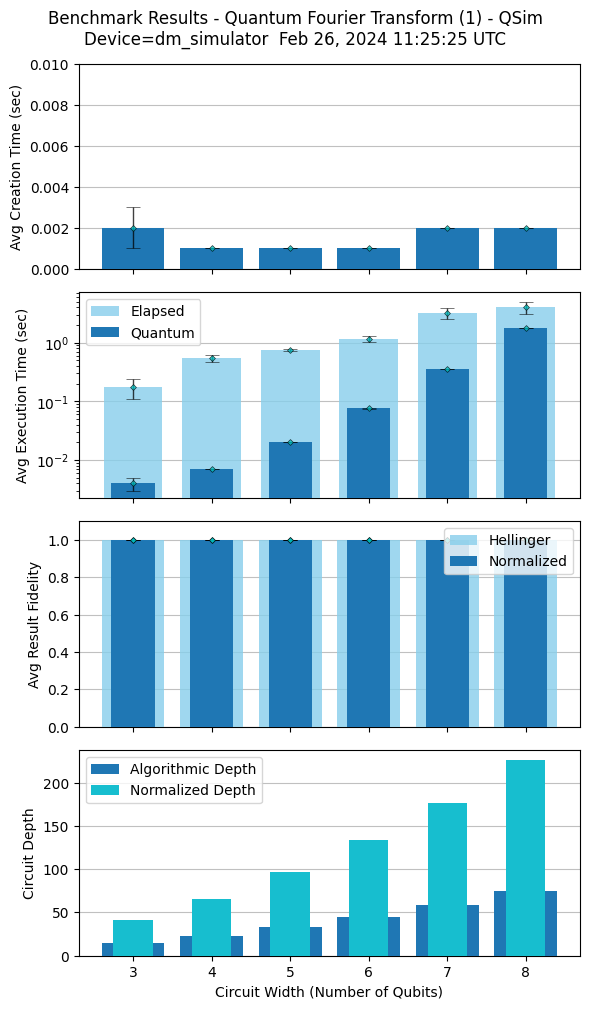

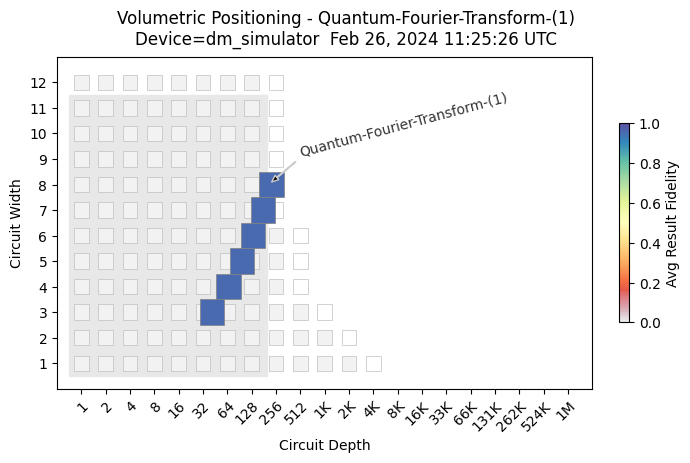

In [8]:
# if main, execute method 1
if __name__ == '__main__': run()